**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing required libraries**

In [ ]:
import tensorflow as tf
from keras import layers,models,applications
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten,Input, Lambda, GlobalMaxPooling2D
from keras.models import Model,Sequential
from keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

### **Importing the Data Using the ImageDataGenerator**

In [ ]:
data_train_path = r"/content/drive/MyDrive/Colab Notebooks/Minor Project/Corn (Maize)/Train"
data_test_path = r"/content/drive/MyDrive/Colab Notebooks/Minor Project/Corn (Maize)/Test"
data_valid_path = r"/content/drive/MyDrive/Colab Notebooks/Minor Project/Corn (Maize)/Val"

IMG_SIZE = 256
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
   rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(data_train_path,target_size=(224, 224),shuffle = True, batch_size = BATCH_SIZE, class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(data_test_path,target_size=(224, 224), shuffle = False, batch_size = BATCH_SIZE, class_mode = 'categorical') #24
valid_set = test_datagen.flow_from_directory(data_valid_path,target_size=(224, 224),shuffle = False,batch_size=BATCH_SIZE,class_mode='categorical') #23

Found 7326 images belonging to 4 classes.
Found 184 images belonging to 4 classes.
Found 1645 images belonging to 4 classes.


In [ ]:
labels = train_set.classes
class_names = list(train_set.class_indices.keys())

**Image Visualisation**

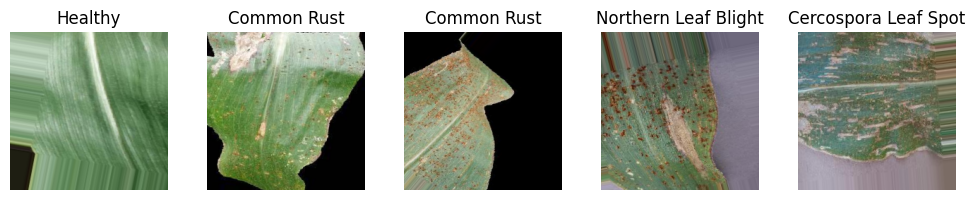

In [ ]:
batch_images, batch_labels = train_set.next()

image_size_inches = 2.0
num_images_to_display = 5
fig_width = image_size_inches * 5
fig_height = image_size_inches
fig, axes = plt.subplots(1, 5, figsize=(fig_width, fig_height))

for i in range(num_images_to_display):

    image = batch_images[i]
    label = batch_labels[i]
    class_name = class_names[label.argmax()]

    axes[i].imshow(image)
    axes[i].set_title(f'{class_name}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


**Defining and Merging 2 pretrained models**

In [ ]:
nasNet = applications.NASNetMobile(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
convNet = applications.ConvNeXtBase(weights="imagenet", include_top=False,input_shape=(224, 224, 3))

for layer in nasNet.layers: layer.trainable=False
for layer in convNet.layers: layer.trainable=False

input_tensor = Input(shape=(224, 224, 3))
from keras.layers import concatenate

first = nasNet(input_tensor)
first_pooling = GlobalMaxPooling2D(data_format='channels_last')(first)
output1 = Dense(128, activation='relu')(first_pooling)

second = convNet(input_tensor)
second_pooling = GlobalMaxPooling2D(data_format='channels_last')(second)
output2 = Dense(128, activation='relu')(second_pooling)

merged_output = concatenate([output1, output2])
output3 = Dense(4, activation = 'softmax')(merged_output)

merged = Model(inputs=input_tensor, outputs=output3)



350926856/350926856 [==============================] - 2s 0us/step


In [ ]:

merged.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy","categorical_accuracy"])

In [ ]:
merged.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 NASNet (Functional)         (None, 7, 7, 1056)           4269716   ['input_3[0][0]']             
                                                                                                  
 convnext_base (Functional)  (None, 7, 7, 1024)           8756646   ['input_3[0][0]']             
                                                          4                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 1056)                 0         ['NASNet[0][0]']          

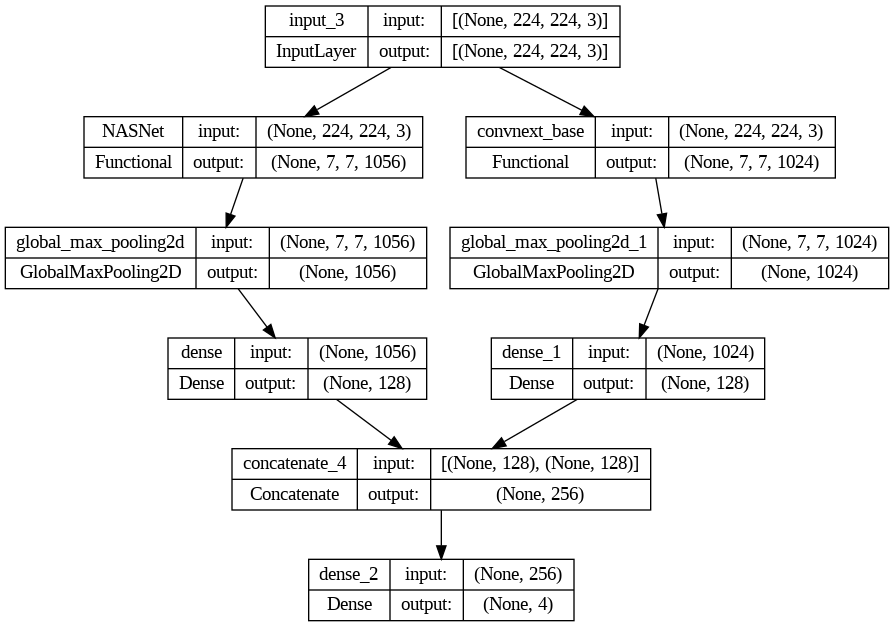

In [ ]:
plot_model(merged, "/content/drive/MyDrive/Colab Notebooks/Minor Project/architecture.png", show_shapes=True)

**Training the Model for 25 epochs**

In [ ]:
model_history=merged.fit(train_set , validation_data=valid_set, epochs=25,validation_steps=32 ,verbose=1)

Epoch 1/25
229/229 [==============================] - 1646s 7s/step - loss: 0.3915 - accuracy: 0.8664 - categorical_accuracy: 0.8664 - val_loss: 0.2160 - val_accuracy: 0.9131 - val_categorical_accuracy: 0.9131
Epoch 2/25
229/229 [==============================] - 192s 839ms/step - loss: 0.2135 - accuracy: 0.9182 - categorical_accuracy: 0.9182 - val_loss: 0.0833 - val_accuracy: 0.9697 - val_categorical_accuracy: 0.9697
Epoch 3/25
229/229 [==============================] - 184s 803ms/step - loss: 0.1767 - accuracy: 0.9330 - categorical_accuracy: 0.9330 - val_loss: 0.1104 - val_accuracy: 0.9590 - val_categorical_accuracy: 0.9590
Epoch 4/25
229/229 [==============================] - 184s 801ms/step - loss: 0.1551 - accuracy: 0.9425 - categorical_accuracy: 0.9425 - val_loss: 0.0967 - val_accuracy: 0.9609 - val_categorical_accuracy: 0.9609
Epoch 5/25
229/229 [==============================] - 185s 807ms/step - loss: 0.1470 - accuracy: 0.9428 - categorical_accuracy: 0.9428 - val_loss: 0.1490 

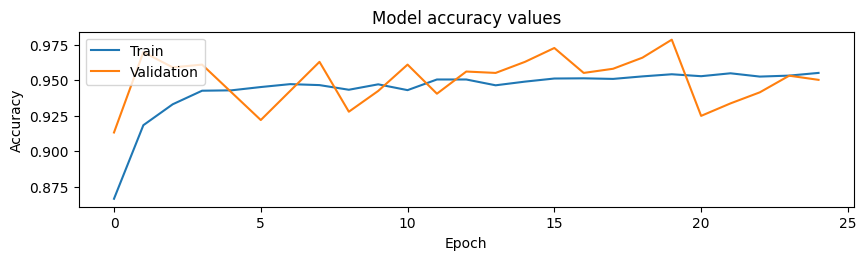

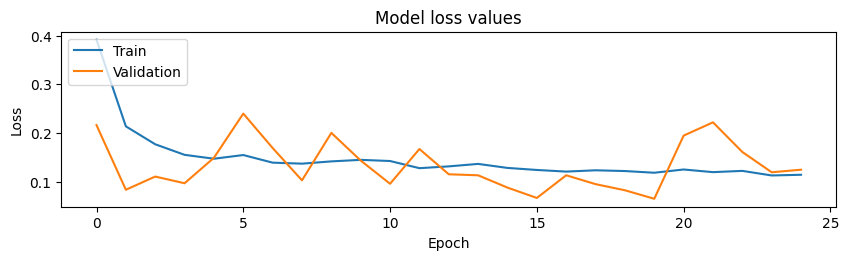

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(2,1,2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Evaluating the Model**

In [ ]:
merged.evaluate(test_set)

6/6 [==============================] - 41s 8s/step - loss: 0.1821 - accuracy: 0.9348 - categorical_accuracy: 0.9348


[0.1820746660232544, 0.9347826242446899, 0.9347826242446899]

In [ ]:
predictions = merged.predict(test_set)
predicted_classes = np.argmax(predictions, axis=1)

6/6 [==============================] - 12s 611ms/step


In [ ]:
#Classification Report
from sklearn.metrics import classification_report, confusion_matrix
true_labels= test_set.classes

#CLASSIFICATION REPORT
import pandas as pd
cr =classification_report(true_labels,predicted_classes,output_dict = True)
df = pd.DataFrame(cr).transpose()
df

,precision,recall,f1-score,support
0,0.875000,0.853659,0.864198,41.000000
1,0.979592,1.000000,0.989691,48.000000
2,1.000000,0.978723,0.989247,47.000000
3,0.877551,0.895833,0.886598,48.000000
accuracy,0.934783,0.934783,0.934783,0.934783
macro avg,0.933036,0.932054,0.932433,184.000000
weighted avg,0.934880,0.934783,0.934721,184.000000


[[35  0  0  6]
 [ 0 48  0  0]
 [ 1  0 46  0]
 [ 4  1  0 43]]


<Axes: >

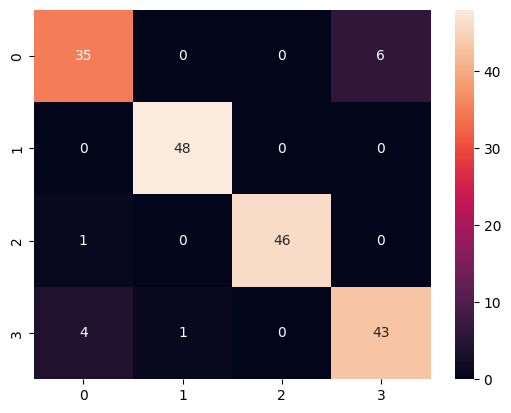

In [ ]:
#Confusion Matrix
cm = confusion_matrix(true_labels,predicted_classes)
print(cm)

import seaborn as sns
sns.heatmap(cm, annot=True)

In [ ]:
#Other metrics such as Sensitivity, Specificity, F1 Score
n = cm.shape[0]
for class_index in range(n):
        true_positives = cm[class_index, class_index]
        false_positives = cm[class_index].sum() - true_positives
        false_negatives = cm[:, class_index].sum() - true_positives
        true_negatives = cm.sum() - (true_positives + false_positives + false_negatives)

        # Ensure values are not zero for division (avoid NaNs)
        true_positives = max(true_positives, 1e-8)
        false_positives = max(false_positives, 1e-8)
        false_negatives = max(false_negatives, 1e-8)

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
sensitivity = recall  # Same as recall in multi-class case
f1_score = 2 * (precision * recall) / (precision + recall)

metrics={}

metrics[class_index] = {
            "precision": precision,
            "recall": recall,
            "specificity": specificity,
            "sensitivity": sensitivity,
            "f1_score": f1_score
        }

print(metrics)

{3: {'precision': 0.8958333333333334, 'recall': 0.8775510204081632, 'specificity': 0.9629629629629629, 'sensitivity': 0.8775510204081632, 'f1_score': 0.8865979381443299}}


In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(labels)
label_onehot = label_binarizer.transform(true_labels)
print(label_onehot.shape ) #

(184, 4)


Precision Recall Curve

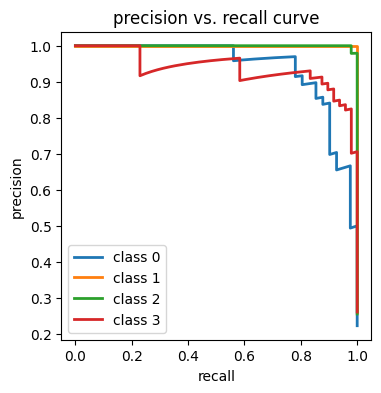

In [ ]:
from sklearn.metrics import precision_recall_curve
precision = dict()
recall = dict()

plt.figure(figsize=(4,4))
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve( label_onehot[:, i],
                                                        predictions[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

ROC Curve

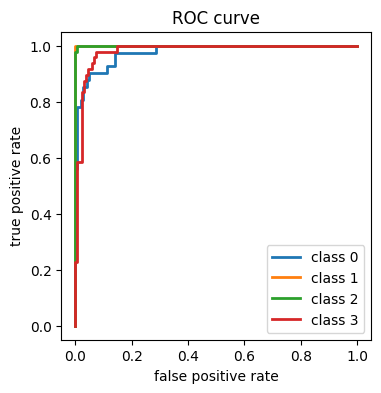

In [ ]:
# roc curve
from sklearn.metrics import roc_curve

fpr = dict()
tpr = dict()

plt.figure(figsize=(4,4))
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(label_onehot[:, i],predictions[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

### **Explaning the model : X-AI(LIME, SHAP)**

In [ ]:
!pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

In [ ]:

from skimage import io
from skimage import transform
image_path = "/content/drive/MyDrive/Colab Notebooks/Minor Project/Corn (Maize)/Test/Cercospora Leaf Spot/07f54257-0ec8-4bce-991f-90d46646d4f8___RS_GLSp 4378 copy 2.jpg"
image = io.imread(image_path)
resized_image1 = transform.resize(image, (1,224, 224,3))
resized_image2 = transform.resize(image, (224, 224,3))

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         resized_image2,
         merged.predict
)


In [ ]:
image, mask = explanation.get_image_and_mask(
         merged.predict(
               resized_image1
         ).argmax(axis=1)[0],
         positive_only=True,
         hide_rest=False)

1/1 [==============================] - 0s 95ms/step


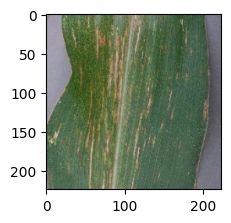

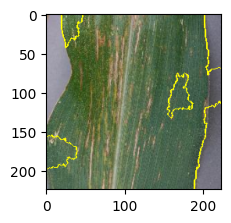

In [ ]:
plt.figure(figsize=(5,5))
plt.subplot(2,1,1)
plt.imshow(image)

plt.figure(figsize=(5,5))
plt.subplot(2,1,2)
plt.imshow(mark_boundaries(image, mask))